In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from datetime import datetime, date, timedelta
from scipy import stats

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [7]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect= True)

In [9]:
columns = inspector.get_columns("station")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
Base = automap_base()

Base.prepare(engine, reflect=True)

Base.classes.keys()

['measurement', 'station']

In [11]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
session = Session(engine)

# Exploratory Climate Analysis

In [13]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x25149ab2288>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1}

In [14]:
latest_date = (
                session
                .query(Measurement.date)
                .order_by(Measurement.date.desc())
                .first()
                ._asdict()
                )

In [15]:
latest_date_f = dt.datetime.strptime(latest_date['date'],'%Y-%m-%d')
start_date = dt.date(latest_date_f.year -1,latest_date_f.month, latest_date_f.day)

In [16]:
start_date_fmt = f"{start_date.year}-{'{:02d}'.format(start_date.month)}-{'{:02d}'.format(start_date.day)}"

In [17]:
print(f"Latest date on the database is: {latest_date['date']}")
print(f'Query will start 1 year before this latest date. Query starts on: {start_date_fmt}')

Latest date on the database is: 2017-08-23
Query will start 1 year before this latest date. Query starts on: 2016-08-23


In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
lastYear = (
                session
                .query(Measurement.date, Measurement.prcp)
                .filter(Measurement.date >= start_date)
                .filter(Measurement.date <= latest_date['date'])
                .order_by(Measurement.date.asc())
                .all()
)

In [19]:
prcp_df = (
            pd
            .DataFrame(lastYear)
            .set_index('date')
)

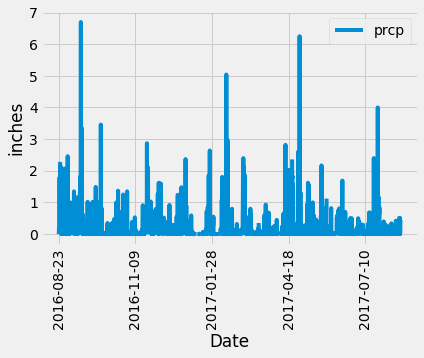

<Figure size 432x288 with 0 Axes>

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(kind='line', rot =90)

plt.xlabel('Date')
plt.ylabel('inches')
plt.legend(loc="best")
plt.show()
plt.savefig("Historical Precipitation(Inches).png")

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
# Design a query to show how many stations are available in this dataset?
query_stations= session.query(Measurement.station).distinct().all()
query_stations
print(f"{query_stations} different weather stations are used to make precipitation measurements")

[('USC00519397',), ('USC00513117',), ('USC00514830',), ('USC00517948',), ('USC00518838',), ('USC00519523',), ('USC00519281',), ('USC00511918',), ('USC00516128',)] different weather stations are used to make precipitation measurements


In [23]:
activeStations = ( 
               session
              .query(Measurement.station, Station.name, func.count(Measurement.station))
              .group_by(Measurement.station)
              .join(Station, Measurement.station == Station.station)
              .order_by(func.count(Measurement.station).desc())
              .all()
              )
activeStations

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
high_temp = session.query(func.max(Measurement.tobs).\
                          filter(Measurement.station == activeStations[0][0])).all()
low_temp = session.query(func.min(Measurement.tobs).\
                          filter(Measurement.station == activeStations[0][0])).all()
avg_temp = session.query(func.avg(Measurement.tobs).\
                          filter(Measurement.station == activeStations[0][0])).all()

In [28]:
# Choose the station with the highest number of temperature observations.
activeStation = activeStations[0]
print(f"The most active weather station is {activeStation[0]}({activeStation[1]}) with {activeStation[2]} measurements made")

The most active weather station is USC00519281(WAIHEE 837.5, HI US) with 2772 measurements made


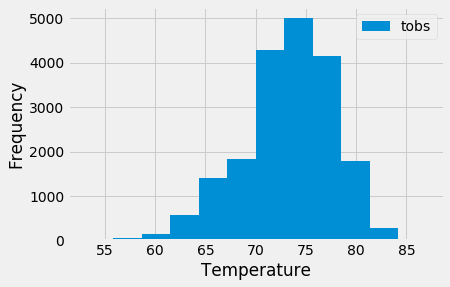

In [21]:
# Query the last 12 months of temperature observation data for this station and 
active_temp = session.query(Measurement.tobs)


flat_list = []
for sublist in active_temp:
    for item in sublist:
        flat_list.append(item)
active_temp = flat_list        
        
# plot the results as a histogram                                  
plt.hist(active_temp, bins = 12, label= 'tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.show
plt.savefig("Frequency vs Temperature Last 12 Months.png")


## Bonus Challenge Assignment

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Request user to input vacation dates
trip_startDate = input("When is your vacation starting? ('YYYY-MM-DD'): ")
trip_endDate = input("When is your vacation coming to an end? ('YYYY-MM-DD'): ")

# Calculate last year's date
trip_startDate_f = dt.datetime.strptime(trip_startDate,'%Y-%m-%d')
trip_endDate_f = dt.datetime.strptime(trip_endDate,'%Y-%m-%d')
prevYearStart = dt.date(trip_startDate_f.year -1,trip_startDate_f.month, trip_startDate_f.day)
prevYearEnd = dt.date(trip_endDate_f.year -1,trip_endDate_f.month, trip_endDate_f.day)


# Request last year's weather data
reqData = calc_temps(prevYearStart,prevYearEnd)

# If last year's data is not available, then go back enough years to get 
# valid data for the inputted dates

# Initialize variables
factor = 1

# While weather data is invalid, keep going back an extra year until valid seasonal data can be retrieved
while reqData[0][0] == None:
        factor +=1
        print(f"\nLast year's data was not found. Going back {factor} year(s)...")
        prevYearStart = dt.date(trip_startDate_f.year -factor,trip_startDate_f.month, trip_startDate_f.day)
        prevYearEnd = dt.date(trip_endDate_f.year -factor,trip_endDate_f.month, trip_endDate_f.day)
        reqData = calc_temps(prevYearStart,prevYearEnd)

# Format dates
prevYearStart_f = f"{prevYearStart.year}-{'{:02d}'.format(prevYearStart.month)}-{'{:02d}'.format(prevYearStart.day)}"
prevYearEnd_f = f"{prevYearEnd.year}-{'{:02d}'.format(prevYearEnd.month)}-{'{:02d}'.format(prevYearEnd.day)}"
minReqData = round(reqData[0][0],2)
avgReqData = round(reqData[0][1],2)
maxReqData = round(reqData[0][2],2)

# Print results to screen
print(f"\nFor a vacation starting on {trip_startDate}, ending on {trip_endDate}, the following data is available:")
print(f"Data from {factor} years ago, ({prevYearStart_f} to {prevYearEnd_f}):")
print(f'''Minimum Temperature: {minReqData} deg F
Maximum Temperature: {maxReqData} deg F
Average Temperature: {avgReqData} deg F''')   


When is your vacation starting? ('YYYY-MM-DD'): 2020-09-09
When is your vacation coming to an end? ('YYYY-MM-DD'): 2020-09-16

Last year's data was not found. Going back 2 year(s)...

Last year's data was not found. Going back 3 year(s)...

Last year's data was not found. Going back 4 year(s)...

For a vacation starting on 2020-09-09, ending on 2020-09-16, the following data is available:
Data from 4 years ago, (2016-09-09 to 2016-09-16):
Minimum Temperature: 71.0 deg F
Maximum Temperature: 83.0 deg F
Average Temperature: 77.19 deg F


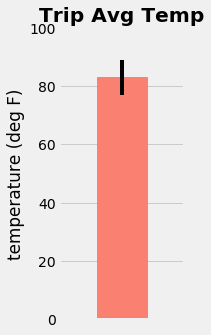

<Figure size 432x288 with 0 Axes>

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = np.array([avgReqData-minReqData,maxReqData-avgReqData])
plt.figure(figsize=(2,5))
plt.bar(1,
        reqData[0][2],
        yerr=yerr.reshape(2,1),
        color="salmon",
        edgecolor="grey")

# Format bar graph
plt.title("Trip Avg Temp", fontweight='bold')
plt.ylabel('temperature (deg F)')
plt.xlim(0,2)
plt.ylim(0,100)
plt.xticks([])

# Display plot
plt.show()
plt.savefig("tmin, tavg, and tmax for my Vacations.png")

In [26]:

# Calculate the total amount of rainfall per weather station for your trip dates 
# using the previous year's matching dates.
# Sort this in descending order by precipitation amount 
# and list the station, name, latitude, longitude, and elevation

# Query the total historical rainfall experienced during vacation days
# as measured by every weather station
rainfall = (
            session
            .query(Measurement.station, 
                   Station.name, 
                   Station.latitude,
                   Station.longitude,
                   Station.elevation,
                   func.sum(Measurement.prcp))
            .join(Station, Measurement.station == Station.station)
            .filter(Measurement.date >= prevYearStart)
            .filter(Measurement.date <= prevYearEnd)
            .group_by(Measurement.station)
            .order_by(func.sum(Measurement.prcp).desc())
            .all()
            )

# Convert query into dataframe
rainfall_df = pd.DataFrame(rainfall,columns=["Station","Station Name","Lat","Lon","Elv","Total Prcp"])  

# Display dataframe
rainfall_df

,Station,Station Name,Lat,Lon,Elv,Total Prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,15.01
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,4.42
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2.59
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.47
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.90
5,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.64
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00


In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
    """Daily Normals.
    Args:
        date (str): A date string in the format '%m-%d'
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
vDays = (prevYearEnd - prevYearStart) + dt.timedelta(days=1)

delta_t = np.arange(1,vDays.days)
dates = [trip_startDate_f.strftime('%Y-%m-%d')]
for d in delta_t:
    dates.append((trip_startDate_f + dt.timedelta(days=int(d))).strftime('%Y-%m-%d'))

normals = []
for date in dates:
    # Strip off the year and save a list of %m-%d strings
    timestring = date[-5:]
    temp = daily_normals(timestring)
    normals.append([temp [0][0],temp [0][1],temp [0][2]])  
    



In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ["tmin","tavg","tmax"])
dates_df = pd.DataFrame(dates, columns = ["date"])

# Concatenate date and normals dataframes
trip_df = pd.concat([dates_df,normals_df], axis=1).set_index('date')
trip_df.index = trip_df.index.map(str)

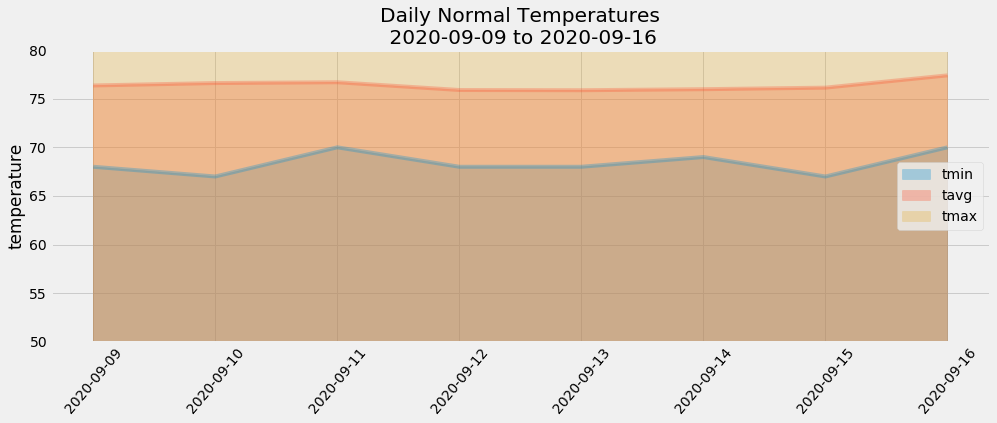

<Figure size 432x288 with 0 Axes>

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
(
    trip_df
    .plot
    .area(stacked=False,
          figsize=(15,5),
          alpha = 0.3)
)

# Format plot
plt.title(f"Daily Normal Temperatures\n {dates[0]} to {dates[len(dates)-1]}",fontweight="light")
plt.xticks(rotation = 50)
plt.xlabel("")
plt.ylabel("temperature")
plt.ylim(50,80)
plt.legend(loc="right")
# Display the plot
plt.show()
plt.savefig("Daily Normal Temperatures.png")